In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scienceplots
from utils import *
plt.style.use(['science','no-latex', 'grid', 'nature'])
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import dates, cm, colors
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from traffic.data import eurofirs
from cartopy.crs import *
from cartopy.feature import COASTLINE, BORDERS
from cartes.utils.features import countries, ocean, lakes
from cartopy import feature
import numpy as np
import glob
import contextlib
from PIL import Image
from matplotlib.patches import ConnectionPatch
import numpy as np
from scipy.special import binom

In [5]:
# Load data
df = pd.read_csv('query_results/region_flights_data_2016-2023_07_23.csv')
airports = pd.read_csv('query_results/airports.csv')

In [6]:
# Drop missing airport values
airport_coords = airports[['gps_code', 'coordinates', 'iso_country']].dropna()

# Split latitute and lonitute
airport_coords['Latitude'] = airport_coords['coordinates'].apply(lambda t: t.split(', ')[1]).astype(float)
airport_coords['Longitude'] = airport_coords['coordinates'].apply(lambda t: t.split(', ')[0]).astype(float)
airport_coords = airport_coords.drop(columns = 'coordinates').rename(columns = {'gps_code': 'Airport', 'iso_country': 'Country'})

# 1. Airport Traffic Clusters Using K-Means:

In [7]:
# Count departures per airport
departure_counts = df['estdepartureairport'].value_counts().reset_index()
departure_counts.columns = ['Airport', 'Departures']

# Count arrivals per airport
arrival_counts = df['estarrivalairport'].value_counts().reset_index()
arrival_counts.columns = ['Airport', 'Arrivals']

# Join the departure and arrival counts into a traffic dataframe
airport_traffic = pd.merge(departure_counts, arrival_counts, on='Airport', how='outer').fillna(0)
airport_traffic = airport_traffic.merge(airport_coords, on='Airport')

In [8]:
# Scale data using Z-score
scaler = StandardScaler()

# Apply k-means clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(
    scaler.fit_transform(airport_traffic[['Departures', 'Arrivals']])    
)
airport_traffic['Cluster'] = kmeans.labels_

In [10]:
# Group by country for another per country clustering
country_traffic = airport_traffic.groupby('Country').agg({'Departures': 'sum', 'Arrivals': 'sum'}).reset_index()

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(
    scaler.fit_transform(country_traffic[['Departures', 'Arrivals']])    
)
country_traffic['Cluster'] = kmeans.labels_

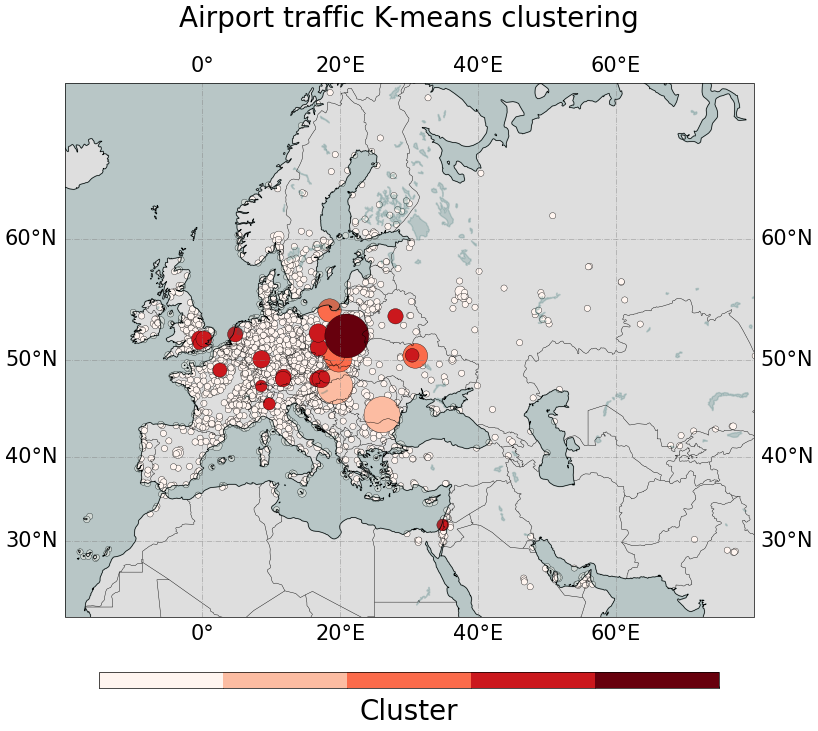

In [168]:
plt.style.use(['science','no-latex', 'grid', 'nature'])
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

# Initialize the Basemap
crs = PlateCarree()
projection = Mercator()

fig, ax = plt.subplots(1, 1, frameon=True, figsize=(16, 9), subplot_kw=dict(projection=projection))
ax.add_feature(lakes(scale="50m"))
ax.add_feature(ocean(scale="50m"))
ax.add_feature(COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(BORDERS.with_scale("50m"), lw=0.3)
ax.set_facecolor("#dedede")
gl = ax.gridlines(crs=crs, draw_labels=True, linewidth=.6, color='gray', alpha=0.5, linestyle='-.')

cmap = cm.Reds
norm = colors.BoundaryNorm(np.arange(k+1), cmap.N)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

airport_traffic = airport_traffic.sort_values(by='Cluster', ascending=True)
x, y = airport_traffic['Longitude'], airport_traffic['Latitude']
mx_scaler = MinMaxScaler(feature_range=(10, 500))
sz = mx_scaler.fit_transform(airport_traffic[['Departures', 'Arrivals']])
size = sz[:, 0] + sz[:, 1]
c = airport_traffic['Cluster']

ax.scatter(x, y, s=size, c=c, cmap=cmap, norm=norm, alpha=1, zorder=1, transform=crs, edgecolor='k', linewidth=0.25)
plt.colorbar(ax=ax, mappable=mapper, ticks = [], orientation='horizontal', shrink=0.5, pad=0.08, aspect=40, label = 'Cluster')
ax.set_title('Airport traffic K-means clustering', y=1.09)

ax.set_extent((-20, 80, 20, 60), crs)

plt.savefig('clustering/airport_traffic.png', bbox_inches=None, dpi=150)

# 2. Aircraft Utilization Patterns Using Hierarchical Clustering:

In [11]:
# Convert timestamps to datetime objects
df['firstseen'] = pd.to_datetime(df['firstseen'], unit='s')
df['lastseen'] = pd.to_datetime(df['lastseen'], unit='s')

# Calculate total flight time and number of flights for each aircraft
df['flight_time'] = (df['lastseen'] - df['firstseen']).dt.total_seconds()
aircraft_metrics = df.groupby('icao24').agg({'flight_time': 'sum', 'day': 'count'}).reset_index()
aircraft_metrics.columns = ['icao24', 'Total_Flight_Time', 'Number_of_Flights']

In [12]:
# Scale the metrics
scaler = StandardScaler()
aircraft_metrics[['Total_Flight_Time', 'Number_of_Flights']] = scaler.fit_transform(aircraft_metrics[['Total_Flight_Time', 'Number_of_Flights']])

In [13]:
# Run agglomerative clustering
agg_clust = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_clust.fit(aircraft_metrics[['Total_Flight_Time', 'Number_of_Flights']])

# AgglomerativeClustering doesn't provide a dendrogram, but you can analyze the cluster labels
# and the number of aircraft in each cluster
aircraft_metrics['Cluster'] = agg_clust.labels_
cluster_sizes = aircraft_metrics['Cluster'].value_counts()

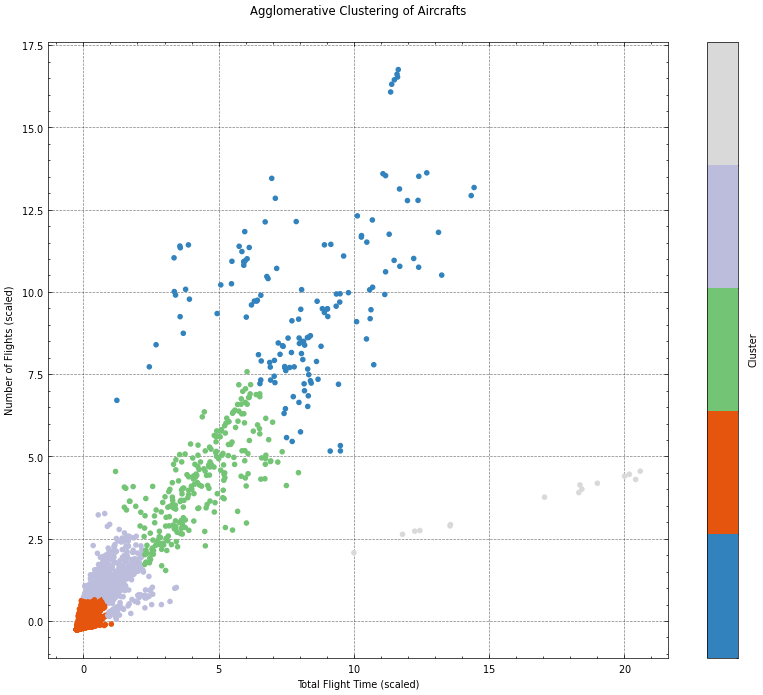

In [15]:
# Assuming `aircraft_metrics` has been scaled and clustered
# and 'Cluster' column contains the cluster labels from AgglomerativeClustering

cmap = cm.tab20c
norm = colors.BoundaryNorm(np.arange(aircraft_metrics['Cluster'].max()+2), cmap.N)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(
    aircraft_metrics['Total_Flight_Time'], 
    aircraft_metrics['Number_of_Flights'], 
    c=aircraft_metrics['Cluster'], 
    cmap=cmap,
    norm=norm,
    alpha=1,
)
plt.colorbar(ax=ax, mappable=mapper, ticks = [], label='Cluster')
ax.set_title('Agglomerative Clustering of Aircrafts', y=1.03)
ax.set_xlabel('Total Flight Time (scaled)')
ax.set_ylabel('Number of Flights (scaled)')
plt.savefig('clustering_results/aircraft_clustering.png', bbox_inches=None, dpi=150)

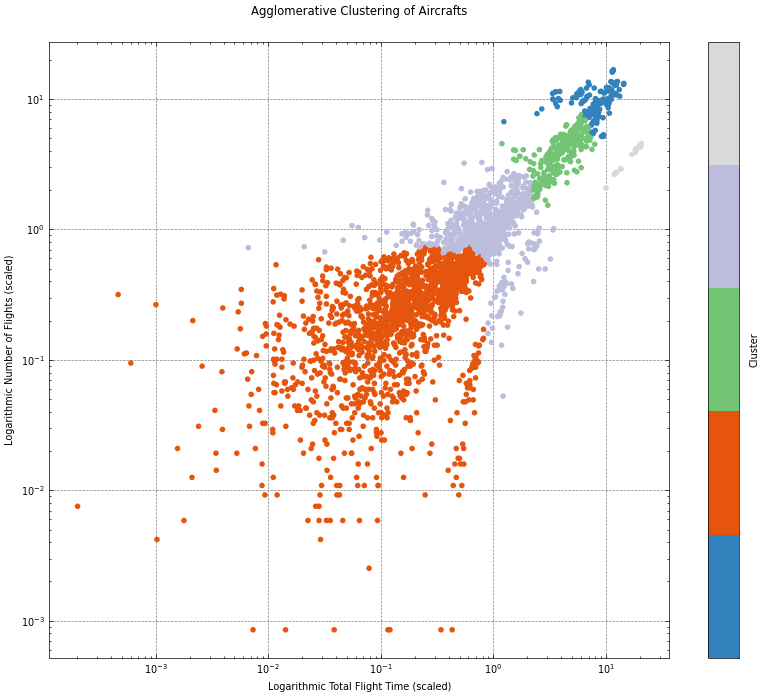

In [16]:
# Logarithmic scale
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(
    aircraft_metrics['Total_Flight_Time'], 
    aircraft_metrics['Number_of_Flights'], 
    c=aircraft_metrics['Cluster'], 
    cmap=cmap,
    norm=norm,
    alpha=1,
)
plt.colorbar(ax=ax, mappable=mapper, ticks = [], label='Cluster')
ax.set_title('Agglomerative Clustering of Aircrafts', y=1.03)
ax.set_xlabel('Total Flight Time (scaled)')
ax.set_ylabel('Number of Flights (scaled)')
ax.set_xlabel('Logarithmic Total Flight Time (scaled)')
ax.set_ylabel('Logarithmic Number of Flights (scaled)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.savefig('clustering_results/aircraft_clustering_log.png', bbox_inches=None, dpi=150)

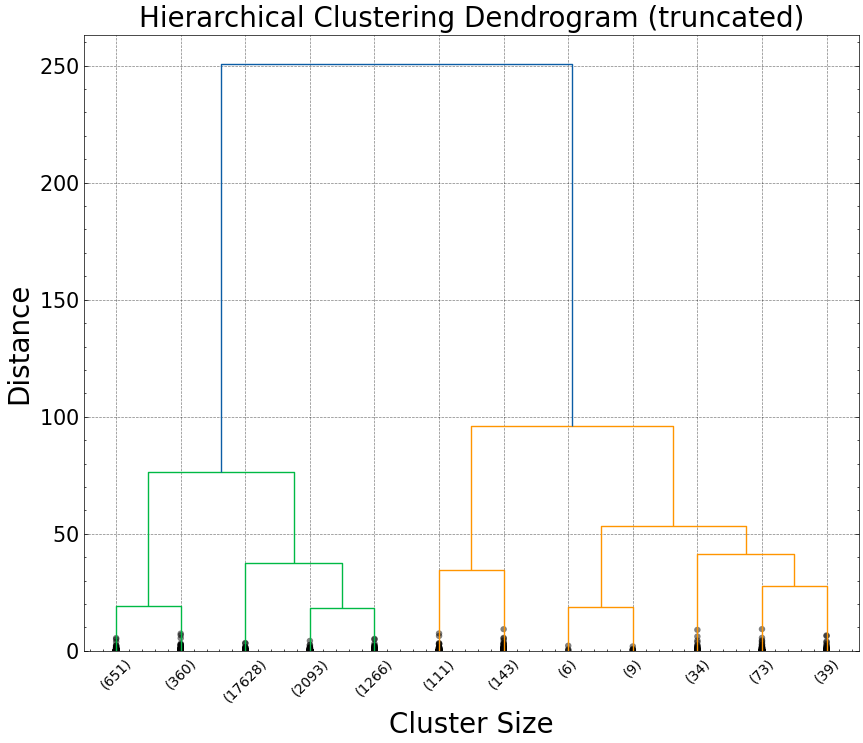

In [176]:
Z = linkage(aircraft_metrics[['Total_Flight_Time', 'Number_of_Flights']], method='ward')

plt.figure(figsize=(10, 8))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()